# Quantum. Lab 5. QFT Quantum Fourier Transform 

Author:
- ***Nikita Makarevich (Student ID: 153989)***

In [3]:
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.visualization import plot_bloch_multivector
from qiskit.circuit import Gate
from qiskit.quantum_info import Operator
from qiskit_aer import Aer
import matplotlib.pyplot as plt
from dataclasses import dataclass
from IPython.display import display

# selection of quantum simulator (or processor)
# backend = Aer.get_backend("qasm_simulator")
backend = Aer.get_backend("aer_simulator")

STUDENT_ID: int = 153989

In [4]:

from qiskit.quantum_info.states.statevector import Statevector
def plot_circuit(circuit: QuantumCircuit, *, ax: plt.Axes | None = None) -> plt.Axes:
    if ax is None:
        fig = plt.figure(figsize=(8, 4))
        ax = fig.add_subplot(111)
    circuit.draw("mpl", ax=ax)
    return ax

def plot_bloch_spheres(backend, circuit: QuantumCircuit):
    circuit_init = circuit.copy()
    circuit_init.save_statevector()
    statevector = backend.run(circuit_init).result().get_statevector()
    # statevector = Statevector(circuit_init)
    fig: plt.Figure = plot_bloch_multivector(statevector, title="Final State Bloch Spheres")
    fig.show()
    display(fig)
    return fig

def run_experiments(
    backend, circuit: QuantumCircuit, *, shots: int = 2048, runs: int = 3
) -> list[dict]:
    compiled_circuit = transpile(circuit, backend)
    return [
        backend.run(compiled_circuit, shots=shots).result().get_counts()
        for _ in range(runs)
    ]

In [5]:
@dataclass
class Setup:
    n: int
    qx: QuantumRegister
    cx: ClassicalRegister | None
    circuit: QuantumCircuit

    @classmethod
    def create_quantum_only(cls, *, n: int = 3, **circuit_kwargs) -> "Setup":
        qx = QuantumRegister(n, "q")
        circ = QuantumCircuit(qx, **circuit_kwargs)
        return cls(n, qx, None, circ)

    @classmethod
    def create(cls, *, n: int = 3, **circuit_kwargs) -> "Setup":
        qx = QuantumRegister(n, "q")
        cx = ClassicalRegister(n, "c")
        circ = QuantumCircuit(qx, cx, **circuit_kwargs)
        return cls(n, qx, cx, circ)

In [6]:
def convert_to_bits(n: int, a: int) -> str:
    return format(a, f"0{n}b")


def connect_initial_encoding(setup: Setup, number: int) -> None:
    bits = convert_to_bits(setup.n, number)
    for i, bit in enumerate(reversed(bits)):
        if bit == "1":
            setup.circuit.x(setup.qx[i])


def connect_barrier(setup: Setup) -> None:
    for q in setup.qx:
        setup.circuit.barrier(q)


def connect_qft_3bit(setup: Setup) -> None:
    if setup.n != 3:
        raise ValueError("QFT 3-bit can only be applied to 3 qubits.")

    setup.circuit.h(2)
    setup.circuit.cp(np.pi/2, 1, 2) # CROT from qubit 1 to qubit 2
    setup.circuit.cp(np.pi/4, 0, 2) # CROT from qubit 2 to qubit 0
    setup.circuit.h(1)
    setup.circuit.cp(np.pi/2, 0, 1) # CROT from qubit 0 to qubit 1
    setup.circuit.h(0)
    setup.circuit.swap(0,2)


def connect_iqft_3bit(setup: Setup) -> None:
    if setup.n != 3:
        raise ValueError("QFT 3-bit can only be applied to 3 qubits.")
    
    setup.circuit.swap(0,2)
    setup.circuit.h(0)
    setup.circuit.cp(-np.pi/2, 0, 1) # CROT from qubit 0 to qubit 1
    setup.circuit.h(1)
    setup.circuit.cp(-np.pi/2, 1, 2) # CROT from qubit 1 to qubit 2
    setup.circuit.cp(-np.pi/4, 0, 2) # CROT from qubit 2 to qubit 0
    setup.circuit.h(2)


def connect_measure_all(setup: Setup) -> None:
    if setup.cx is None:
        raise ValueError("Classical register is not defined in the setup.")
    for i in range(setup.n):
        setup.circuit.measure(setup.qx[i], setup.cx[i])


Input number: 0; Bits: 000


C:\Users\nikit\AppData\Local\Temp\ipykernel_77292\2571777722.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


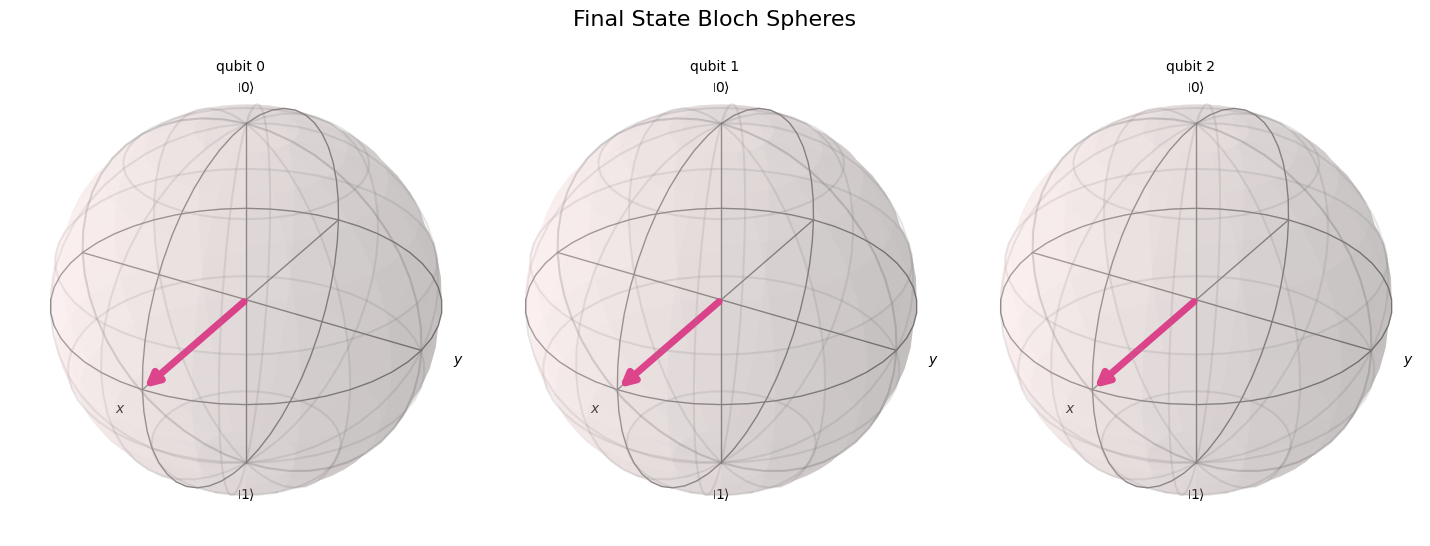

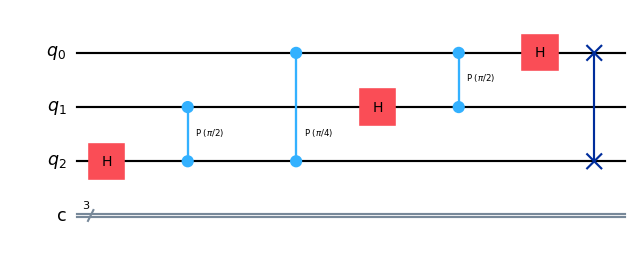


Input number: 1; Bits: 001


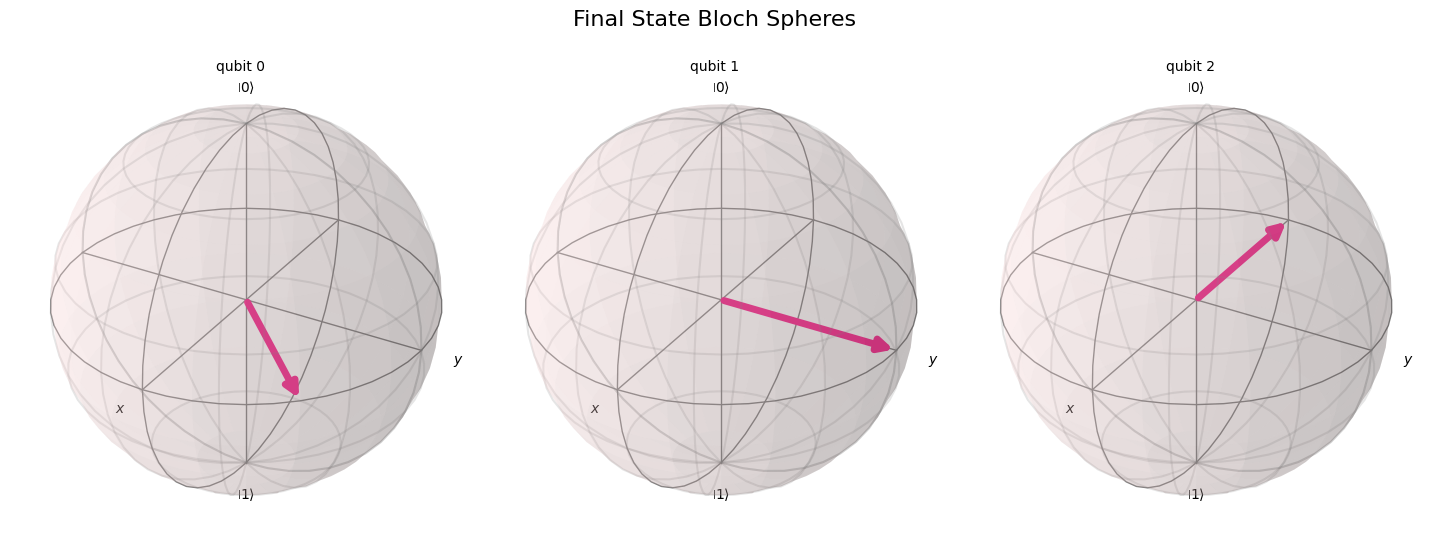

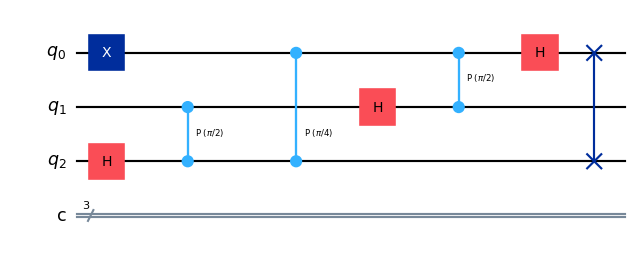


Input number: 2; Bits: 010


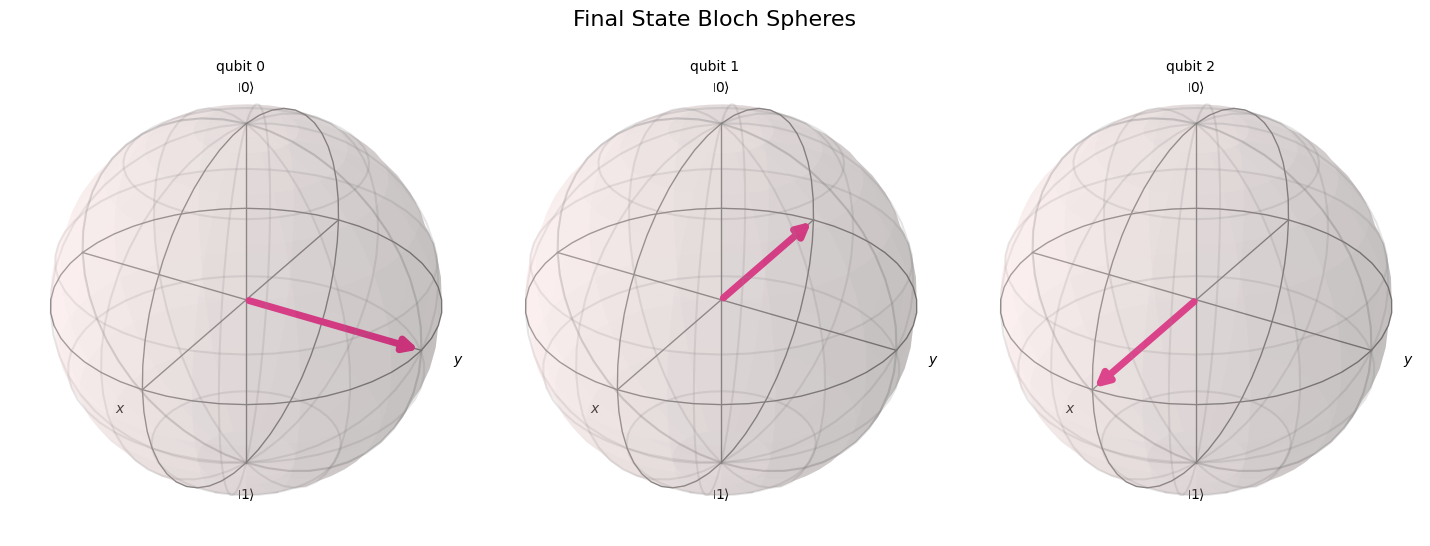

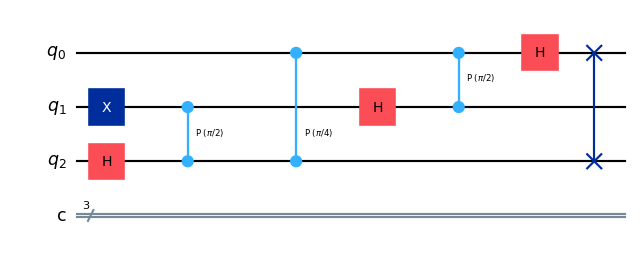


Input number: 3; Bits: 011


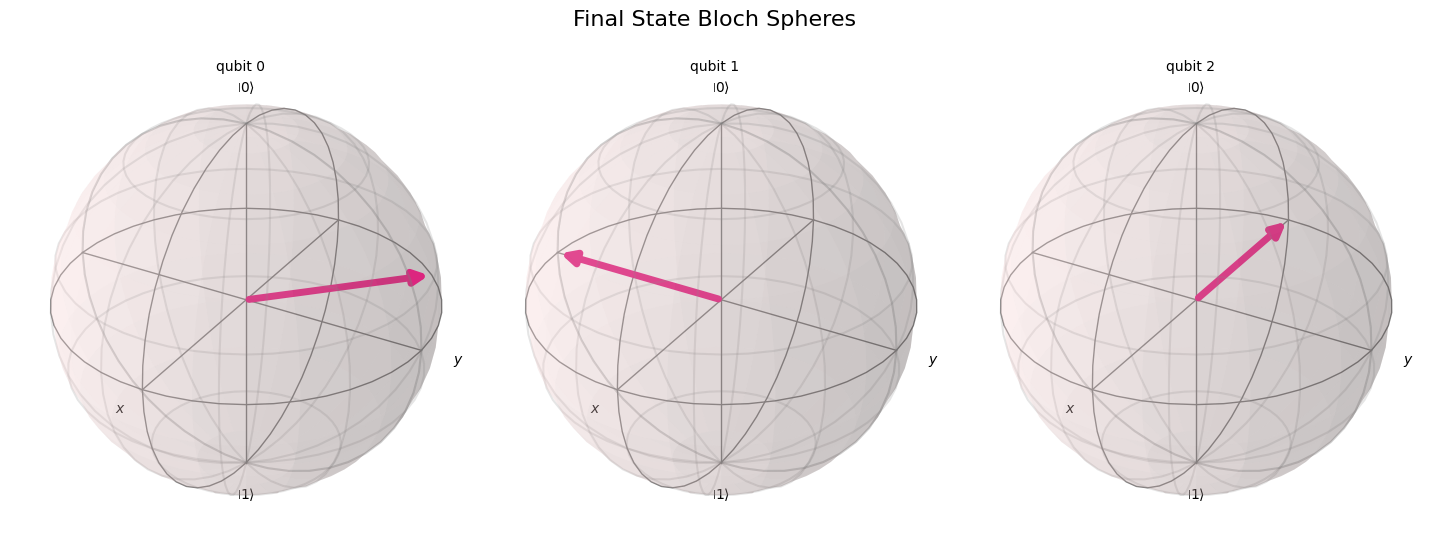

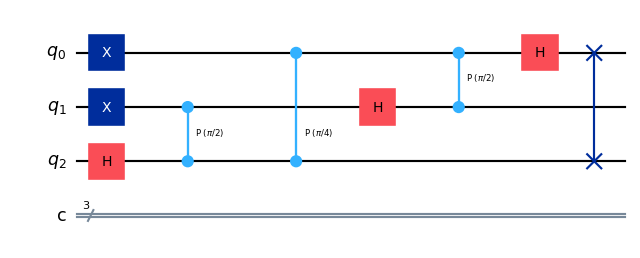


Input number: 4; Bits: 100


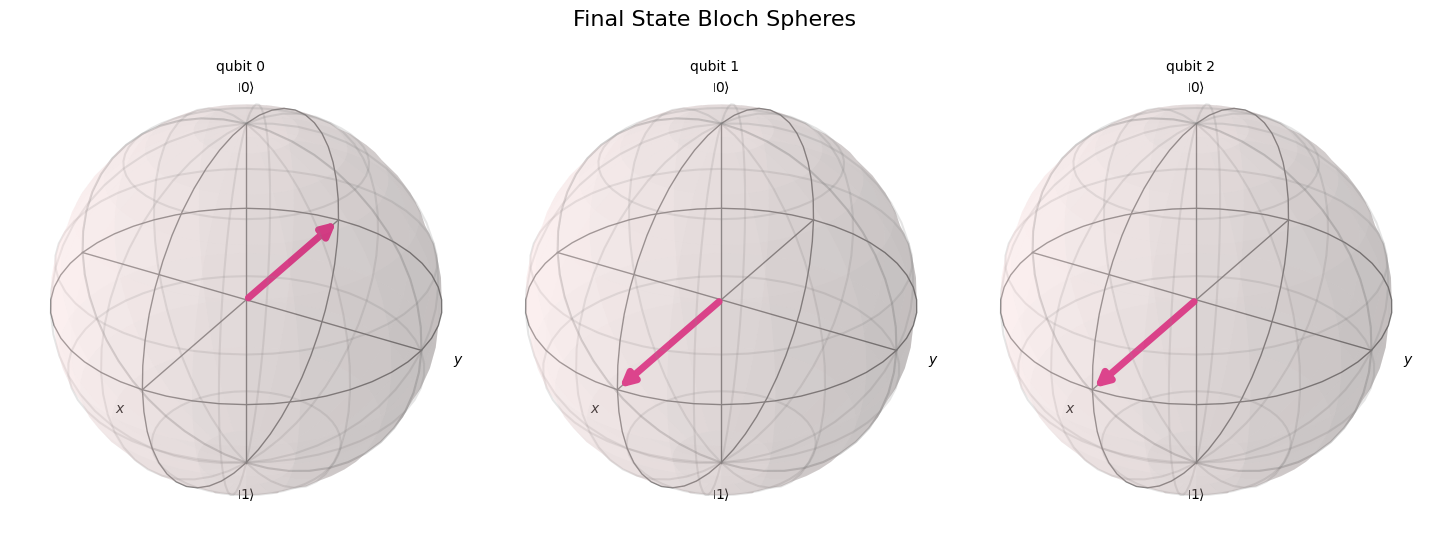

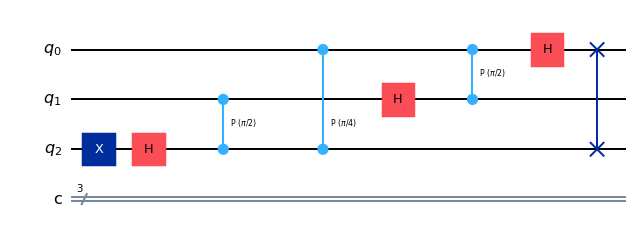


Input number: 5; Bits: 101


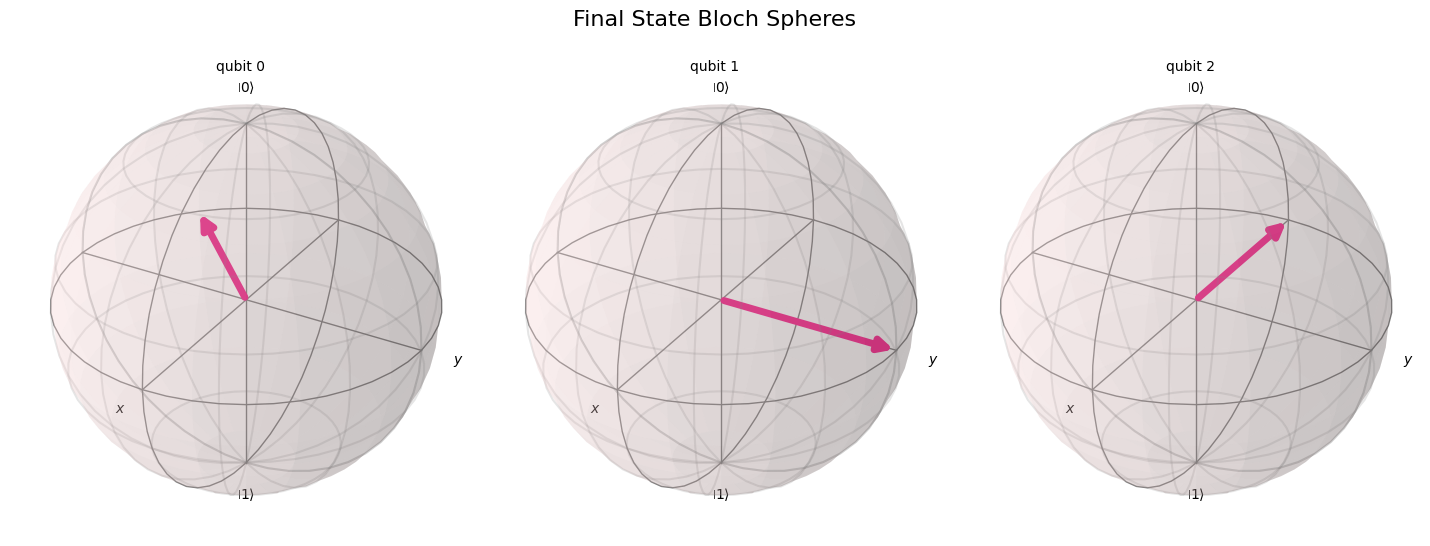

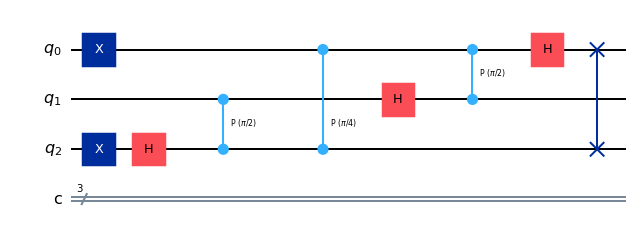


Input number: 6; Bits: 110


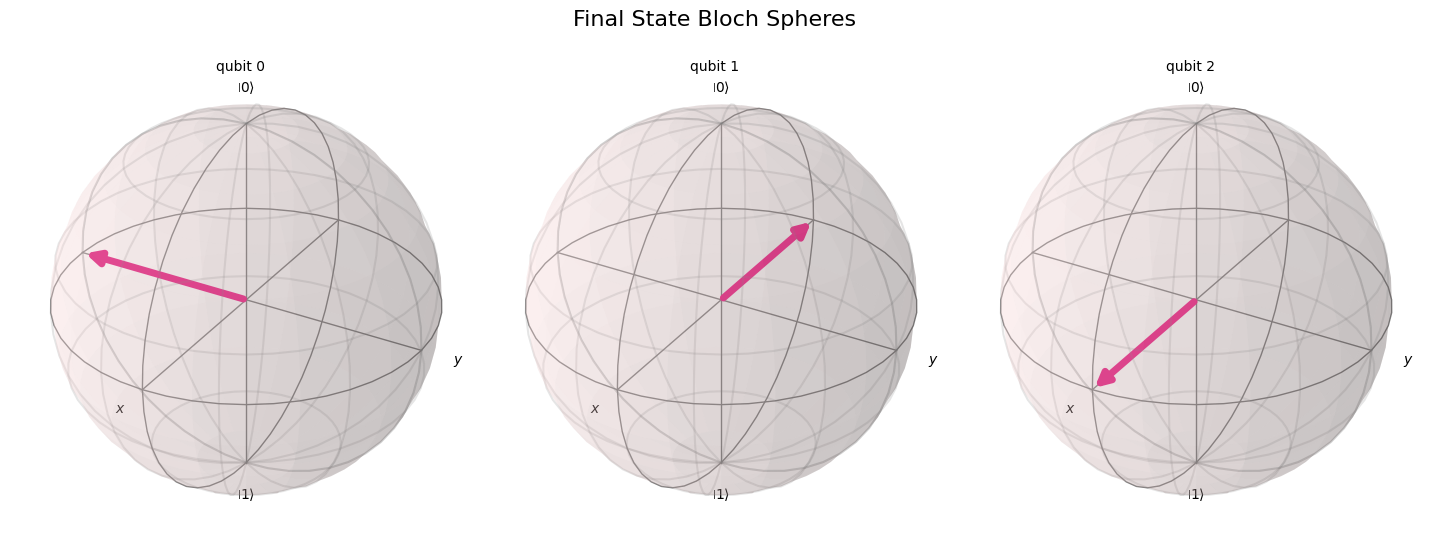

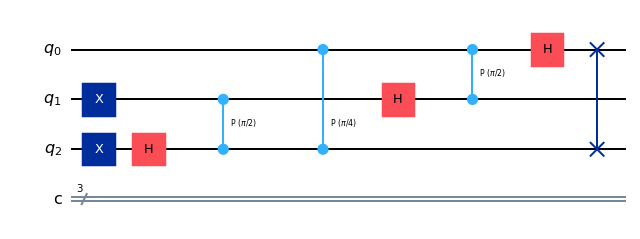


Input number: 7; Bits: 111


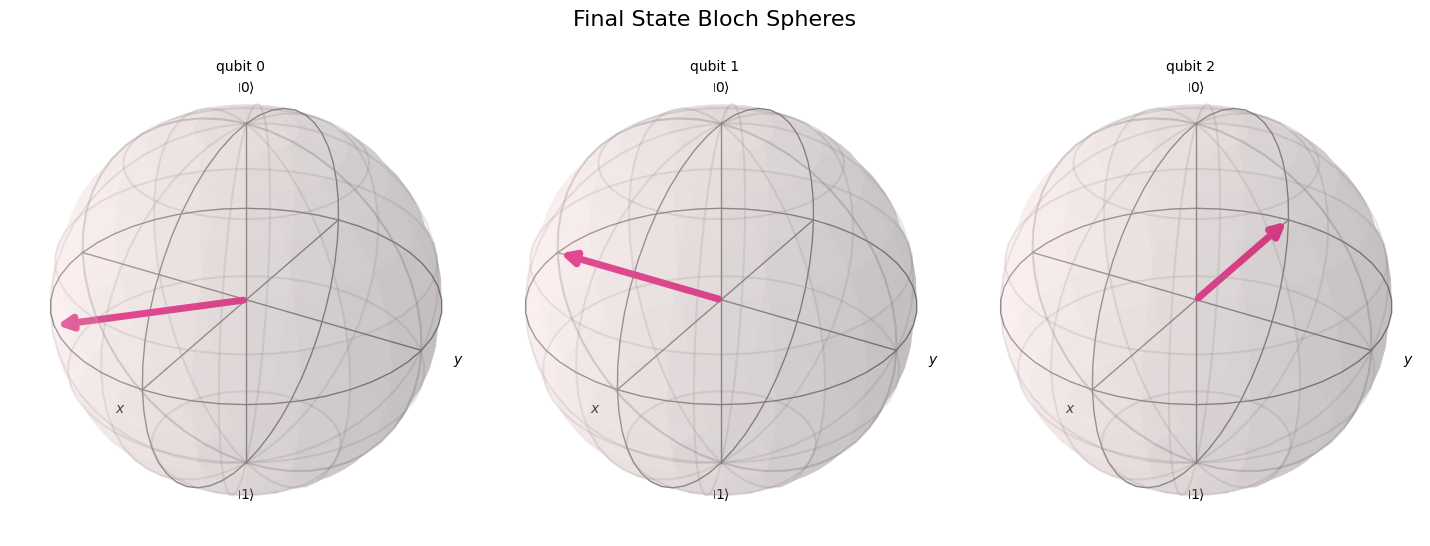

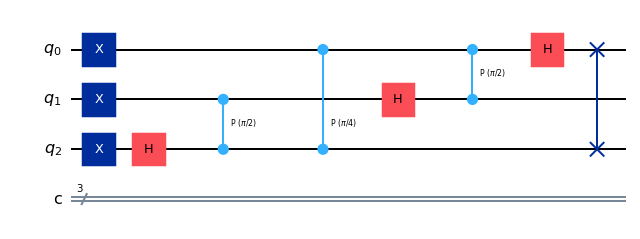

In [7]:
for i in range(8):
    setup = Setup.create(n=3)
    connect_initial_encoding(setup, i)
    connect_qft_3bit(setup)

    print(f"\nInput number: {i}; Bits: {convert_to_bits(3, i)}")
    plot_circuit(setup.circuit)
    plot_bloch_spheres(backend, setup.circuit)
    plt.show()